# Synopsis

Create an LDA topic model from scratch using collapsed Gibbs Sampling.

# Configuration

In [1]:
base_path = '/Users/rca2t/COURSES/DSI/DS5559/UVA_DSI_REPO'
local_lib = base_path + '/lib'
src_dir = base_path + '/play/lda/corpora'
corpus_db = "20news.db"

In [2]:
n_docs = 100
n_topics = 10
n_iters = 1000
alpha = 1
beta = 1

# Libraries

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import re
import random
import sys; sys.path.append(local_lib)
import textman.textman as tx
from sklearn.feature_extraction.text import TfidfVectorizer

# Pragmas

In [13]:
%matplotlib inline

# Process

## Get corpus

In [4]:
sql = "SELECT * FROM doc ORDER BY RANDOM() LIMIT ?"
with sqlite3.connect(src_dir + "/" + corpus_db) as db:
    docs = pd.read_sql(sql, db, index_col='doc_id', params=(n_docs,))

## Show labels

In [5]:
docs.doc_label.value_counts()

comp.graphics               9
sci.crypt                   8
rec.sport.hockey            7
talk.politics.mideast       6
talk.politics.guns          6
comp.os.ms-windows.misc     6
misc.forsale                6
sci.med                     6
rec.autos                   6
rec.motorcycles             5
sci.space                   5
sci.electronics             5
talk.politics.misc          4
comp.sys.mac.hardware       4
talk.religion.misc          4
soc.religion.christian      4
comp.windows.x              3
rec.sport.baseball          3
alt.atheism                 2
comp.sys.ibm.pc.hardware    1
Name: doc_label, dtype: int64

## Convert corpus to tokens and vocab

In [6]:
tokens, vocab = tx.create_tokens_and_vocab(docs, src_col='doc_content')
tokens['token_num'] = tokens.groupby(['doc_id']).cumcount()
tokens = tokens.reset_index()[['doc_id','token_num','term_id']]
tokens = tokens[tokens.term_id.isin(vocab[vocab.go].index)]
tokens = tokens.set_index(['doc_id','token_num'])

In [7]:
tokens['term_str'] = tokens.term_id.map(vocab.term)

In [8]:
tokens.head()

term_id    term_str
doc_id token_num                     
102818 0              740      anyone
       1             3253        know
       2             1834        dead
       3             2423       first
       4             2557  generation

##  Remove redundant words

In [9]:
# tokens = tokens.reset_index().drop_duplicates(['doc_id','term_id']).set_index(['doc_id','token_num'])

In [10]:
# tokens.head()

term_id    term_str
doc_id token_num                     
102818 0              740      anyone
       1             3253        know
       2             1834        dead
       3             2423       first
       4             2557  generation

## Remove insignificant words

In [11]:
vectorizer = TfidfVectorizer(use_idf=1, stop_words='english', token_pattern=r'[A-Za-z][A-Za-z][A-Za-z]+')
X = vectorizer.fit_transform(docs.doc_content.values.tolist())
v = pd.DataFrame(vectorizer.get_feature_names(), columns=['term_str'])
v['idf'] = vectorizer.idf_

In [17]:
v.sort_values('idf', ascending=False).head(10)

,term_str,idf
0,aaa,4.921973
3146,noticing,4.921973
3125,nobles,4.921973
3126,nod,4.921973
3127,nodomain,4.921973
3129,nope,4.921973
3130,noport,4.921973
3131,nords,4.921973
3132,normal,4.921973
3135,north,4.921973


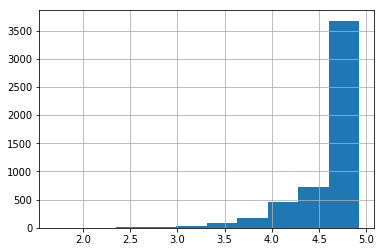

In [18]:
v.idf.hist()

In [19]:
v = v[v.idf > 4.5]
my_v = v.term_str.tolist()

In [20]:
tokens = tokens[tokens.term_str.isin(my_v)]

In [21]:
vocab = vocab[vocab.term.isin(my_v)]

In [23]:
tokens.head(10)

term_id      term_str
doc_id token_num                       
59212  1              869        athena
       2             5722           uga
       4             3578      mcovingt
       8             1695     covington
       12            3294          larc
       23            2187           eng
       41            4041  organization
       44            2569       georgia
       45             870        athens
       46            4163       paulson

## Create topics table

In [24]:
topics = pd.DataFrame(index=range(n_topics))
topics.index.name = 'topic_id'

## Randomly assign topics to tokens

In [25]:
def init_topics(tokens):
    tokens['topic_id'] = np.random.randint(0, n_topics, len(tokens))
    return tokens

In [26]:
tokens = init_topics(tokens)

In [28]:
tokens.head()

term_id   term_str  topic_id
doc_id token_num                              
59212  1              869     athena         9
       2             5722        uga         0
       4             3578   mcovingt         6
       8             1695  covington         2
       12            3294       larc         7

### Generate Count Matrices

In [59]:
def get_DT(tokens):
    return tokens.groupby(['doc_id','topic_id']).topic_id.count()\
        .unstack().fillna(0).astype('int')

In [60]:
def get_WT(tokens):
    return tokens.groupby(['topic_id','term_id']).term_id.count()\
        .unstack().fillna(0).astype('int').T

In [61]:
def print_topics(wt, n=5):    
    wtx = (WT / WT.sum())
    wtx['term_str'] = vocab.term
    wtx = wtx.set_index('term_str')
    for t in topics.index:
        T = wtx[t]
        print('TOPIC', t,  end=': ')
        try:
            print(' '.join(T.sort_values(ascending=False).head(n).index.values))
        except:
            print("NO DICE")

## METHOD 1

See [this blog](http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/).

### Define row function

In [62]:
def get_new_topic(row):
    
    d = row.name[0] # doc_id
    k = row.name[1] # token_num -- NOT USED
    z = row.topic_id
    w = row.term_id
    
    DT.at[d,z] -= 1
    WT.at[w,z] -= 1
    
    p_z = DT.loc[d] * (WT.loc[w] / WT.sum())
    z_weights = p_z / p_z.sum()

    z1 = topics.sample(weights=z_weights).index.values[0]

    DT.at[d,z1] += 1
    WT.at[w,z1] += 1
    
    return z1

### Generate model

In [63]:
tokens = init_topics(tokens)
DT = get_DT(tokens) + alpha
WT = get_WT(tokens) + beta

In [64]:
for i in range(n_iters):
    print(i, end=' ')
    tokens['topic_id'] = tokens.apply(get_new_topic, 1)
print('Done')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [65]:
print_topics(WT, 10)

TOPIC 0: presents ride logic pgp nieuwendyk functions lookup georgia responsible responses
TOPIC 1: stated cheering meeting amiga roberts final lebanese faq stop executive
TOPIC 2: att experienced anti apple bmw blues exe lookup escrow literature
TOPIC 3: frame uga level diet marvel marketing rock canucks saves london
TOPIC 4: suspension goals chance extremely butt yzerman soceity secret serbian sgi
TOPIC 5: armed atheists pens loading helpful sold suddenly records context controller
TOPIC 6: keys pete drivers conference mac cover israelis smart fight medicine
TOPIC 7: absolutely section legal algorithm dec republic possibility posts decisions decade
TOPIC 8: chapter reform mcmanus license gets gld cache gmc tem early
TOPIC 9: language danny prove abiding fleury sgi expensive sick millions falling


## METHOD 2

In [ ]:
def init_theta(dt):
    m = np.ones(topics.shape[0])
    theta = dt.apply(lambda x: pd.Series(np.random.dirichlet(alpha * m)), 1)
    theta.columns.name = 'topic_id'
    return theta

In [ ]:
def init_phi(wt):
    n = np.ones(wt.shape[0])
    phi = wt.apply(lambda x: pd.Series(np.random.dirichlet(beta * n)))
    phi.index.name = 'term_id'
    phi.index = wt.index
    return phi

### Row Function

In [ ]:
def method_2(row):
    
    d = row.name[0] # doc_id
    k = row.name[1] # token_num
    z = row.topic_id
    w = row.term_id
    
    p_z = np.exp(np.log(THETA.loc[d]) + np.log(PHI.loc[w]))
    p_z = THETA.loc[d] * PHI.loc[w]
    p_z = p_z / np.sum(p_z)
    z1 = np.random.multinomial(1, p_z).argmax()
    
    return z1

### Generate model

In [ ]:
tokens = init_topics(tokens)
DT = get_DT(tokens)
WT = get_WT(tokens)
THETA = DT.apply(lambda x: pd.Series(np.random.dirichlet(alpha + x)), 1)
PHI = WT.apply(lambda x: pd.Series(np.random.dirichlet(beta + x)))
PHI.index = WT.index

for i in range(n_iters):
    print(i, end=' ')
    tokens['topic_id'] = tokens.apply(method_2, 1)
    DT = get_DT(tokens)
    WT = get_WT(tokens)
    THETA = DT.apply(lambda x: pd.Series(np.random.dirichlet(alpha + x)), 1)
    PHI = WT.apply(lambda x: pd.Series(np.random.dirichlet(beta + x)))
    PHI.index = WT.index

print()
print_topics(WT, 10)

## METHOD 3

### Compute `P(topic|document)`

`p(topic t | document d)` Where proportion of words in document d that are assigned to topic t

In [ ]:
def get_p_tGd(tokens):
    p_tGd = tokens.reset_index().groupby(['doc_id','topic_id']).token_num.count().to_frame().unstack().fillna(0)
    p_tGd = p_tGd.apply(lambda x: x / x.sum(), axis=1)
    p_tGd.columns = p_tGd.columns.droplevel(0)
    return p_tGd

In [ ]:
p_tGd = get_p_tGd(tokens)

In [ ]:
p_tGd.head()

### Compute `P(word|topic)`
`p(word w | topic t)` Where proportion of assignments to topic t, over all documents d, that come from word w

In [ ]:
def get_p_wGt(tokens):
    p_wGt = tokens.reset_index().groupby(['topic_id','term_id']).token_num.count().to_frame().unstack().fillna(0)
    p_wGt = p_wGt.apply(lambda x: x / x.sum(), axis=1)
    p_wGt.columns = p_wGt.columns.droplevel(0)
    return p_wGt

In [ ]:
p_wGt = get_p_wGt(tokens)

In [ ]:
p_wGt

### Get best topic 

`p(topic t’ | document d) * p(word w | topic t’)`

In [ ]:
def get_best_topic(row, ptd, pwt):
    doc_id = row.name[0]
    token_num = row.name[1]
    term_id = row.term_id
    results = [ptd.at[topic_id, doc_id] * pwt.at[term_id, topic_id] for topic_id in topics.index]
    new_topic = results.index(max(results))
    return new_topic

In [ ]:
tokens = init_topics(tokens)
for i in range(n_iters):
    print(i, end=' ')
    DT = get_DT(tokens)
    WT = get_WT(tokens)
    PTD = (DT.T / DT.T.sum())
    PWT = (WT / WT.sum())
    tokens['topic_id'] = tokens.apply(lambda row: get_best_topic(row, PTD, PWT), axis=1)
print('Done')

### Show Topics

In [ ]:
TOPICS = tokens.groupby(['topic_id','term_id']).term_id.count().to_frame().unstack().fillna(0).T
TOPICS.index = TOPICS.index.droplevel(0)
TOPICS['term_str'] = vocab.term

In [ ]:
for topic_id in topics.index:
    print(topic_id, ', '.join(TOPICS.sort_values(topic_id, ascending=False).head(10).term_str.values))